In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import math
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from scipy.optimize import curve_fit
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [2]:
signals = pd.read_csv("data/train/wind-farm-1-signals-training.csv", sep=";")
signals = signals[["Turbine_ID", "Timestamp", "Grd_Prod_Pwr_Avg", "Amb_WindSpeed_Avg", "Amb_Temp_Avg", "Nac_Temp_Avg", "Rtr_RPM_Avg", "Gear_Bear_Temp_Avg", "Gen_RPM_Avg", "Gen_Bear2_Temp_Avg", "Gen_Bear_Temp_Avg"]]
signals["Timestamp_Datetime"] = pd.to_datetime(signals.Timestamp)
signals.Timestamp_Datetime = signals.Timestamp_Datetime.apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second))
signals_T01 = signals.loc[signals.Turbine_ID == "T01"]
signals_T06 = signals.loc[signals.Turbine_ID == "T06"]
signals_T07 = signals.loc[signals.Turbine_ID == "T07"]
signals_T09 = signals.loc[signals.Turbine_ID == "T09"]
signals_T11 = signals.loc[signals.Turbine_ID == "T11"]

failures = pd.read_csv("data/train/wind-farm-1-failures-training.csv", sep=';')
failures.Timestamp = pd.to_datetime(failures.Timestamp)
failures.Timestamp = failures.Timestamp.apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour, 10 * math.floor(dt.minute / 10), dt.second))

# Detekcja starzenia się części
W oparciu o regresję modelującą zależność wytwarzanej mocy przy konkretnym wietrze.

In [3]:
windframe = signals_T01.loc[(5.0 <= signals_T01.Amb_WindSpeed_Avg) & (signals_T01.Amb_WindSpeed_Avg <= 5.5), :]
windframe["Time"] = windframe.Timestamp_Datetime.dt.month + 12 * (windframe.Timestamp_Datetime.dt.year - min(windframe.Timestamp_Datetime.dt.year))

<ipython-input-3-d5d8ea8d828e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  windframe["Time"] = windframe.Timestamp_Datetime.dt.month + 12 * (windframe.Timestamp_Datetime.dt.year - min(windframe.Timestamp_Datetime.dt.year))


In [4]:
windframe.columns

Index(['Turbine_ID', 'Timestamp', 'Grd_Prod_Pwr_Avg', 'Amb_WindSpeed_Avg',
       'Amb_Temp_Avg', 'Nac_Temp_Avg', 'Rtr_RPM_Avg', 'Gear_Bear_Temp_Avg',
       'Gen_RPM_Avg', 'Gen_Bear2_Temp_Avg', 'Gen_Bear_Temp_Avg',
       'Timestamp_Datetime', 'Time'],
      dtype='object')

### Badanie temperatury przy ustalonym produkowanym prądzie
-------
Na poniższym wykresie widać, że im dłużej używana jest turbina, tym wyższa temperatura przekładni przy tej samej produkcji prądu dla określonego wiartu (od 5.0 do 5.5 m/s).

<AxesSubplot:xlabel='Gear_Bear_Temp_Avg', ylabel='Grd_Prod_Pwr_Avg'>

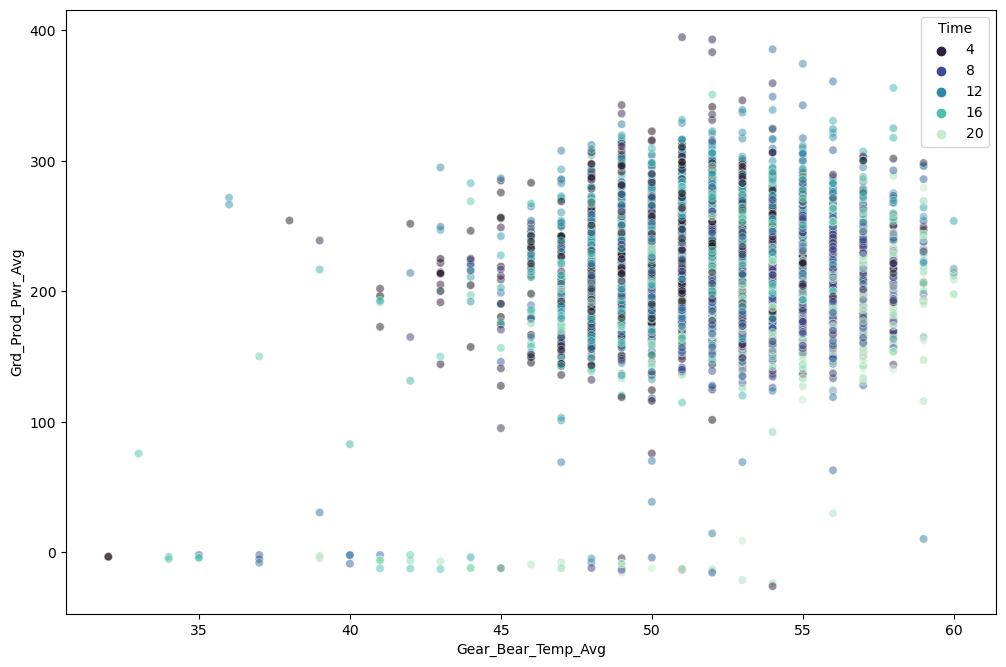

In [5]:
sns.scatterplot(data=windframe.sample(frac=1), x="Gear_Bear_Temp_Avg", y="Grd_Prod_Pwr_Avg", hue="Time", alpha=0.5, palette="mako")

Podobna sytuacja ma miejsce na drugim zestawie trybów w generatorze (ale nie w pierwszym).

<AxesSubplot:xlabel='Gen_Bear2_Temp_Avg', ylabel='Grd_Prod_Pwr_Avg'>

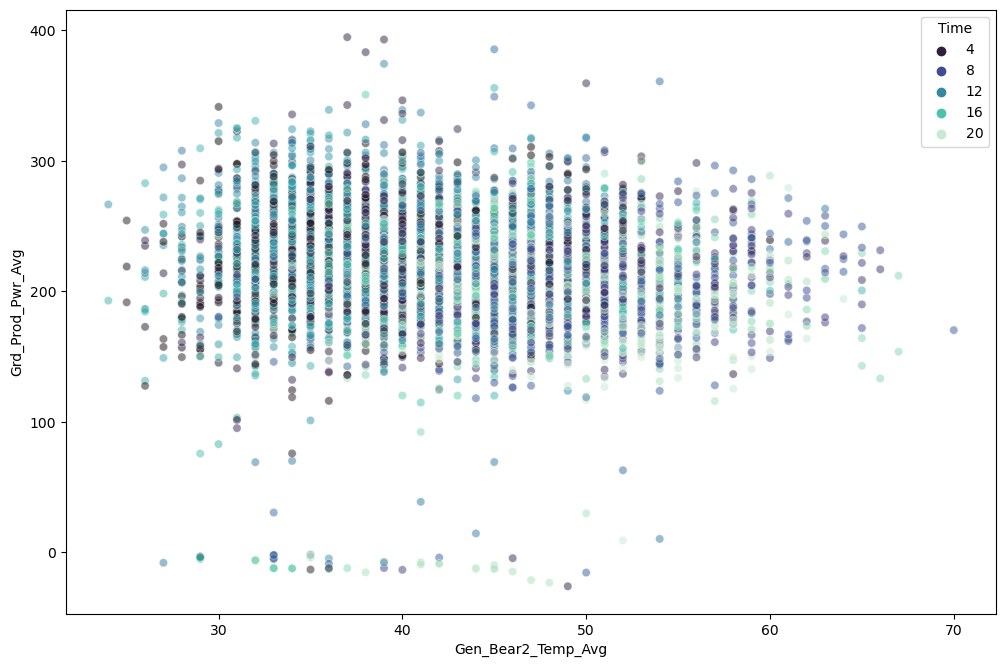

In [6]:
sns.scatterplot(data=windframe.sample(frac=1), x="Gen_Bear2_Temp_Avg", y="Grd_Prod_Pwr_Avg", hue="Time", alpha=0.5, palette="mako")

Ogólnie, cała temperatura wewnątrz komory turbiny zwiększa się wraz z czasem użytkowania generatora. Może być to wskaźnik zużycia turbiny.

<AxesSubplot:xlabel='Nac_Temp_Avg', ylabel='Grd_Prod_Pwr_Avg'>

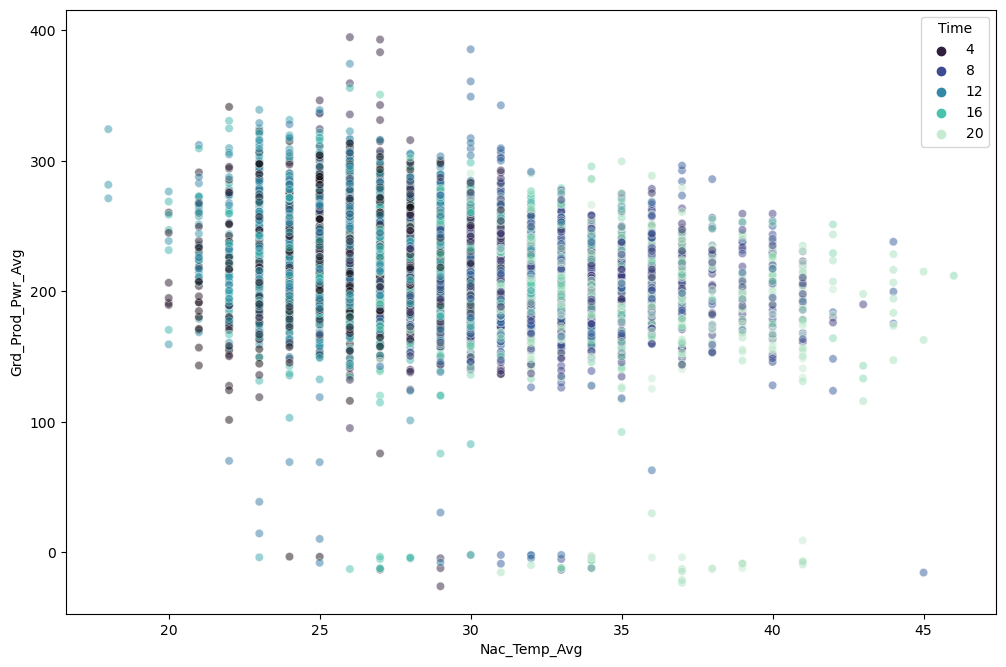

In [7]:
sns.scatterplot(data=windframe.sample(frac=1), x="Nac_Temp_Avg", y="Grd_Prod_Pwr_Avg", hue="Time", alpha=0.5, palette="mako")

### Wnioski z analizy temperatury turbiny
Możemy spróbować dopasować model regresji liniowej: `Grd_Prod_Pwr_Avg ~ Nac_Temp_Avg + Time` trzykrotnie, zamiast temperatury w niecce podstawiając tę na przekładni i generatorze. Współczynnik przy czasie powinien wyjść ujemy i obrazować, jak bardzo zużywa się turbina z każdym miesiącem.

In [8]:
model = LinearRegression().fit(windframe.loc[windframe.Time == 1, ["Nac_Temp_Avg"]], windframe.loc[windframe.Time == 1, 'Grd_Prod_Pwr_Avg'])

In [9]:
print(f"Intercept: {model.intercept_}\nNac_Temp_Avg: {model.coef_[0]}")

Intercept: 184.67387343998655
Nac_Temp_Avg: 1.816527766144568


In [10]:
print(model.score(windframe.loc[windframe.Time == 1, ["Nac_Temp_Avg"]], windframe.loc[windframe.Time == 1, 'Grd_Prod_Pwr_Avg']))

0.006131034791987955


## Podejście oparte na klasteryzacji

Powyższe wykresy nie uwzględniają jednego czynnika - temperatury zewnętrznej, która może mieć istotny wpływ na temperaturę w niecce lub na przekładni i generatorze. W celu pozbycia się takiego czynnika zewnętrznego będziemy każdą obserwację temperatury dzielić przez średnią zewnętrzną temperaturę.

### 1. Płaska klasteryzacja
Regresja na pełnych danych daje mierne wyniki. Grupujemy miesiące w paczki po `p` elementów, a następnie na każdej paczce wywołujemy algorymt `KMeans` w celu utworzenia jednego klastra i poznania współrzędnych jego środka.

### 2. Klasteryzacja z dodatkowym wymiarem
Drugim sposobem przeprowadzenia klasteryzacji będzie utworzenie trójwymiarowych wektorów danych:
`[Grd_Prod_Pwr_Avg, Gear_Bear_Temp_Avg, Time]`

In [11]:
### Poprawienie danych o temperaturze
windframe["Gear_Bear_Temp_Avg_Norm"] = windframe["Gear_Bear_Temp_Avg"] / windframe["Amb_Temp_Avg"]

<ipython-input-11-b9826e515f05>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  windframe["Gear_Bear_Temp_Avg_Norm"] = windframe["Gear_Bear_Temp_Avg"] / windframe["Amb_Temp_Avg"]


<AxesSubplot:xlabel='Gear_Bear_Temp_Avg_Norm', ylabel='Grd_Prod_Pwr_Avg'>

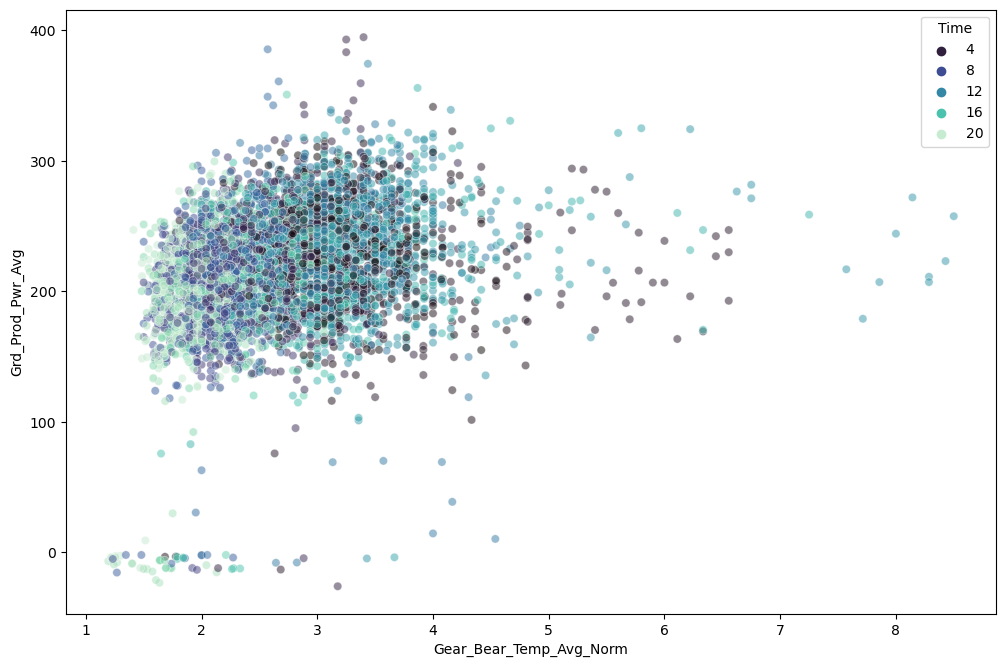

In [12]:
sns.scatterplot(data=windframe.sample(frac=1), x="Gear_Bear_Temp_Avg_Norm", y="Grd_Prod_Pwr_Avg", hue="Time", alpha=0.5, palette="mako")

Istnieje możliwość, że większe różnice w temperaturze występują dlatego, że w zimie na dworze jest znacznie chłodniej niż na przekładni. Jednak to bardzo dobrze - oznacza to, że w praktyce **nie musimy** standaryzować temperatury względem otoczenia, gdyż jest ona niezależna od niej.

### Odcięcie obserwacji odstających
Pomijamy obserwacje z dolnego pasa (okolice zera).

<AxesSubplot:xlabel='Gear_Bear_Temp_Avg_Norm', ylabel='Grd_Prod_Pwr_Avg'>

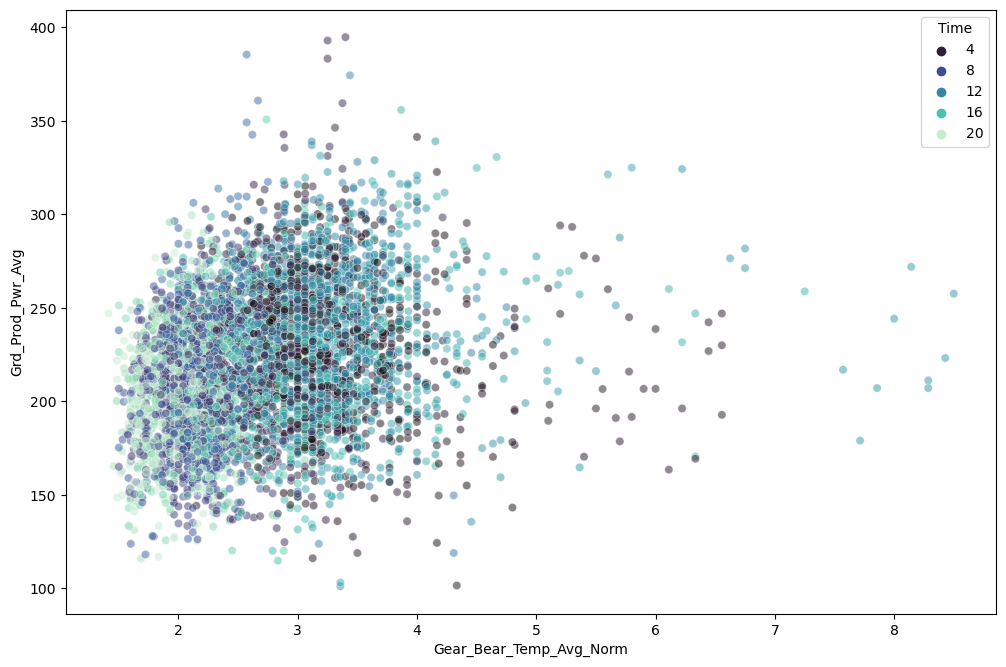

In [19]:
windframe = windframe.loc[windframe.Grd_Prod_Pwr_Avg > 100, :]
sns.scatterplot(data=windframe.sample(frac=1), x="Gear_Bear_Temp_Avg_Norm", y="Grd_Prod_Pwr_Avg", hue="Time", alpha=0.5, palette="mako")

Dla każdego miesiąca obliczamy średnią z punktów.

In [32]:
monthly_mean = windframe.groupby(by="Time").mean().reset_index()
monthly_mean = monthly_mean.iloc[:-1, :] # Ostatni wiersz jest niepełny
monthly_mean

,Time,Grd_Prod_Pwr_Avg,Amb_WindSpeed_Avg,Amb_Temp_Avg,Nac_Temp_Avg,Rtr_RPM_Avg,Gear_Bear_Temp_Avg,Gen_RPM_Avg,Gen_Bear2_Temp_Avg,Gen_Bear_Temp_Avg,Gear_Bear_Temp_Avg_Norm
0,1,231.735052,5.227835,16.469072,25.907216,11.375258,50.989691,1284.321649,39.252577,41.396907,3.126577
1,2,227.026437,5.241954,14.971264,24.770115,11.371264,50.534483,1283.820115,36.810345,40.591954,3.460606
2,3,228.003881,5.242687,15.256716,25.188060,11.364478,50.707463,1283.496119,36.352239,40.892537,3.467628
3,4,232.248553,5.241801,17.926045,27.160772,11.414148,51.276527,1288.750482,41.311897,43.517685,2.907930
4,5,223.869360,5.253872,19.747475,28.734007,11.419192,51.555556,1289.280808,41.218855,45.111111,2.673749
5,6,210.621131,5.258036,23.732143,31.916667,11.369345,53.110119,1283.836607,46.455357,47.446429,2.276297
6,7,203.126941,5.247945,27.684932,35.109589,11.363470,54.356164,1283.529680,50.059361,51.931507,1.980623
7,8,199.039623,5.252201,27.735849,35.383648,11.347799,54.270440,1281.647170,47.383648,53.283019,1.982687
8,9,210.209446,5.255375,24.918567,32.905537,11.380130,53.172638,1285.323127,47.726384,46.980456,2.164039
9,10,220.779221,5.257792,22.269481,30.512987,11.376623,52.185065,1284.689935,44.853896,43.701299,2.368523


<AxesSubplot:xlabel='Time', ylabel='Grd_Prod_Pwr_Avg'>

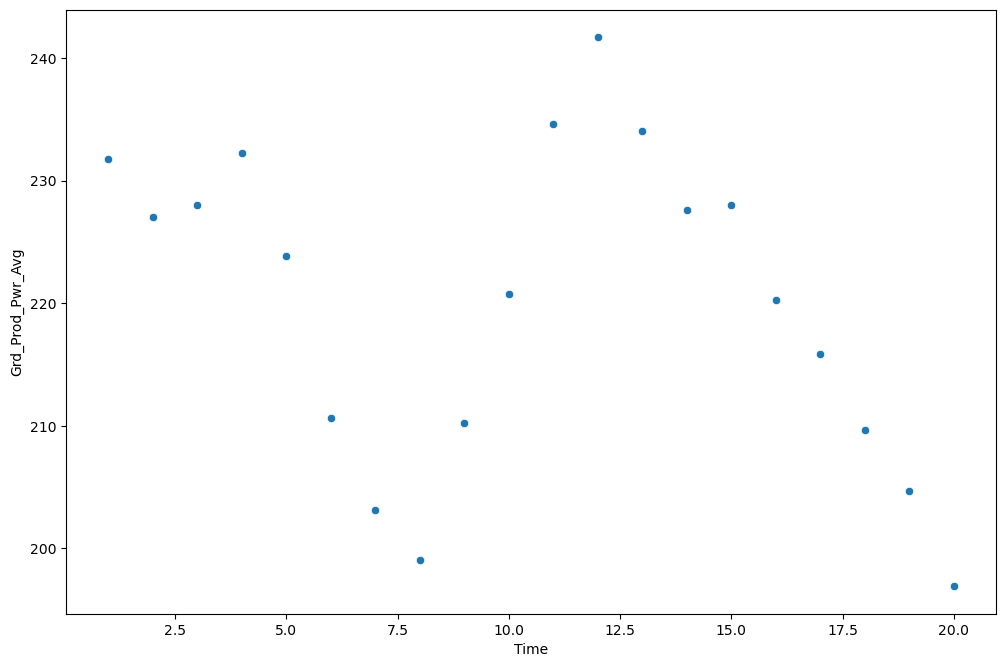

In [33]:
sns.scatterplot(data=monthly_mean, x="Time", y="Grd_Prod_Pwr_Avg")

Cóż... Generowany prąd bardzo mocno zależy od średniej temperatury otoczenia - widać, że w lecie sprawność farmy wiatrowej jest znacznie gorsza. Danych jest stanowczo za mało, żeby cokolwiek wyrokować na temat starzenia się.